# Laboratorio DS Business - La Casa

La popolazione nelle smart cities è in crescita, così come le sfide legate al clima. Queste città sono viste come il nuovo ambiente urbano sostenibile con l'aiuto della digitalizzazione e dell'analisi dei big data.
Attraverso quest'analisi l'obiettivo principale del progetto è quello di immergersi più a fondo nei modelli di consumo e produzione di energia in tutto il mondo, nonchè nelle Smart Cities più performanti.

Più in particolare cercheremo :
-se esiste qualche correlazione fra le regioni con il più alto PIL pro capite e le emissioni di gas a effetto serra
-quali sono l'energie maggiormente utilizzate
-i combustibili fossili sono ancora le fonti energetiche primarire? anche nelle smart cities?
-inoltre cercheremo di fare una predizione sull'utilizzo dei combustibili fossili per capire di conseguenza, se anche nelle regioni aventi le top smart cities si avrà un miglioramento della propagazione dell'effetto serra o meno

Dataset source utilizzati: 
-https://www.kaggle.com/datasets/pralabhpoudel/world-energy-consumption
-https://www.climatewatchdata.org/ghg-emissions?end_year=2019&start_year=1990
-https://blog.threeandahalfroses.com/2020/11/30/the-imd-smart-city-index-2020-report-with-excel-download/

In [312]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import scipy
import math
import collections

# Vizualizzazione
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

#Supervised alghoritm
!pip install xgboost
import xgboost as xgb
!pip install prophet

from prophet import Prophet
#Machine learning library
from sklearn.metrics import mean_absolute_error, mean_squared_error


Ho optato inizialmente per una analisi approfondita del dataset world-energy-consumption

# Preparazione, pulizia e formattazione dei dati

In [313]:
# https://www.kaggle.com/datasets/pralabhpoudel/world-energy-consumption
# Leggiamo il dataset
energyConsumption=pd.read_csv('./datasets/World Energy Consumption.csv')

# Visualizziamo le varie info come ad esempio il numero di colonne, in alternativa potevamo utilizzare il 
# metodo .shape per avere righe e colonne
energyConsumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17432 entries, 0 to 17431
Columns: 122 entries, iso_code to wind_energy_per_capita
dtypes: float64(119), int64(1), object(2)
memory usage: 16.2+ MB


In [314]:
# Verifichiamo inizialmente la presenza di valori nulli, per ogni attributo
missing = energyConsumption.isnull().sum()
missing

iso_code                                    1802
country                                        0
year                                           0
coal_prod_change_pct                        9987
coal_prod_change_twh                        7038
gas_prod_change_pct                        12570
gas_prod_change_twh                         9539
oil_prod_change_pct                        10911
oil_prod_change_twh                         8867
energy_cons_change_pct                      7590
energy_cons_change_twh                      7540
biofuel_share_elec                         13226
biofuel_elec_per_capita                    13243
biofuel_cons_change_pct                    16913
biofuel_share_energy                       13148
biofuel_cons_change_twh                    11923
biofuel_consumption                        11806
biofuel_cons_per_capita                    11806
carbon_intensity_elec                      16844
coal_share_elec                            12376
coal_cons_change_pct

In [315]:
# Mostro come indice la media (da 0 a 1) dei valori mancanti sull' intero dataset
n=missing.sum()/np.product(energyConsumption.shape)
n

0.6808610883319917

Sembra che manchino molti dati e selezionando intervalli di tempo diversi, si vede che ci sono più dati per gli ultimi anni. Se rimuoviamo tutte le righe con dati mancanti, ne rimarrà solo una piccola parte

In [316]:
#Creiamo un dataframe con i calcoli dettagliati della % dei valori mancanti

missingna=energyConsumption.isna().sum() / len(energyConsumption) * 100 
missingna[missingna>0].sort_values(ascending=False)
missingnadf=pd.DataFrame(missingna)
pd.set_option('display.max_rows', 122)
missingnadf.head(10)

,0
iso_code,10.34
country,0.00
year,0.00
coal_prod_change_pct,57.29
coal_prod_change_twh,40.37
gas_prod_change_pct,72.11
gas_prod_change_twh,54.72
oil_prod_change_pct,62.59
oil_prod_change_twh,50.87
energy_cons_change_pct,43.54


Poiché mancano i dati per i primi anni, mi concentrerò sui decenni più recenti in cui sono disponibili più dati grezzi.
Ci sono molti valori null quindi sostituiamo i valori Null con dei valori di "riempimento" (forward/backward filling)

In [317]:
# ffill propaga l'ultima osservazione valida in avanti per sostituire il valore null
# bfill usa l'osservazione valida successiva per sostituire il valore null
energyConsumption.replace([np.inf, -np.inf], np.nan, inplace=True)
energyConsumption=energyConsumption.fillna(method='ffill').fillna(method='bfill')

In [318]:
#Formatto i float per evitare le notazioni scientifiche
pd.options.display.float_format = '{:,.2f}'.format

In [319]:
# Mostriamo la descrizione statistica del dataframe
energyConsumption.describe()

,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,energy_cons_change_twh,biofuel_share_elec,...,solar_elec_per_capita,solar_energy_per_capita,gdp,wind_share_elec,wind_cons_change_pct,wind_share_energy,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_energy_per_capita
count,"17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00",...,"17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00"
mean,"1,973.09",1.41,7.71,"53,596,431,849,477.59",22.41,11.27,18.48,3.70,38.94,1.82,...,56.82,231.44,"592,751,650,164.06",2.64,47.34,1.79,14.56,128.96,157.39,651.74
std,34.33,456.89,113.32,"7,076,352,952,043,702.00",119.52,218.23,168.17,19.62,273.06,4.07,...,131.62,337.33,"3,767,631,093,166.43",5.91,"2,035.47",3.11,60.33,555.56,394.49,"1,155.95"
min,"1,900.00",-100.00,"-2,326.87",-100.00,"-1,054.32",-100.00,"-2,239.74",-92.63,"-6,083.41",0.00,...,0.00,0.00,"196,308,000.00",0.00,-100.00,0.00,-10.41,0.00,0.00,0.00
25%,"1,946.00",-4.07,0.00,-2.16,0.00,-2.74,-0.05,-1.01,-0.15,0.00,...,0.00,1.87,"17,433,516,032.00",0.00,6.17,0.00,0.00,0.00,0.00,0.00
50%,"1,983.00",0.00,0.00,0.00,0.00,0.00,0.00,2.27,0.46,0.09,...,1.52,51.81,"62,722,076,672.00",0.01,14.18,0.42,0.18,1.68,0.14,81.76
75%,"2,002.00",3.38,0.21,3.61,2.45,3.18,2.74,6.16,7.97,1.37,...,29.97,413.25,"253,000,000,000.00",2.01,28.20,2.53,3.07,18.02,64.36,863.17
max,"2,020.00","44,965.75","3,060.59","934,293,000,000,000,000.00","2,112.97","25,500.00","2,790.61","1,487.99","6,446.81",33.91,...,825.09,"1,763.67","107,000,000,000,000.00",56.34,"242,384.84",20.66,428.74,"3,540.05","2,825.43","6,928.36"


Come possiamo vedere i dati richiedono pulizia (alcuni valori NaN), così come probabilmente alcuni valori anomali. 
Anche la colonna "anno" dovrebbe essere convertita in numeri interi

In [320]:
# Convertiamo la data dell'anno da float a intero

energyConsumption['year']=pd.to_datetime(energyConsumption['year'], format='%Y')
energyConsumption['year']=energyConsumption['year'].dt.year

In [321]:
# Aggiungo una colonna con calcoli addizionali

energyConsumption['gdp_per_capita']=energyConsumption['gdp']/energyConsumption['population']

Faccio un altro check sui valori "Null" e "NaN"

In [322]:
# Check valori null
energyConsumption.isnull().sum()

iso_code                  0
country                   0
year                      0
coal_prod_change_pct      0
coal_prod_change_twh      0
                         ..
wind_cons_change_twh      0
wind_consumption          0
wind_elec_per_capita      0
wind_energy_per_capita    0
gdp_per_capita            0
Length: 123, dtype: int64

In [323]:
# Check valori NaN
# DataFrame.any con il parametro axis=1 controla se esiste almeno un true nella riga del nostro dataframe
nandf=energyConsumption[energyConsumption.isna().any(axis=1)]
nandf

,iso_code,country,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,...,solar_energy_per_capita,gdp,wind_share_elec,wind_cons_change_pct,wind_share_energy,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_energy_per_capita,gdp_per_capita


In [324]:
# Facciamo un double check che non ci siano più valori null
energyConsumption.notnull().sum()

iso_code                  17432
country                   17432
year                      17432
coal_prod_change_pct      17432
coal_prod_change_twh      17432
                          ...  
wind_cons_change_twh      17432
wind_consumption          17432
wind_elec_per_capita      17432
wind_energy_per_capita    17432
gdp_per_capita            17432
Length: 123, dtype: int64

Qui di seguito andremo a creare una lista di tutte la nazioni presenti nel nostro dataframe in modo tale da effettuare delle analisi 

In [325]:
countriesList=[]        
x=[countriesList.append(country) for country in energyConsumption['country'] if country not in countriesList]
countriesList

['Afghanistan',
 'Africa',
 'Albania',
 'Algeria',
 'American Samoa',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Asia Pacific',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'CIS',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Central America',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Cook Islands',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Czechoslovakia',
 'Democratic Republic of Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Eastern Africa',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Europe',

In [326]:
# Assegniamo degli index alle colonne per poterle analizzare separatamente

x=-1
for column in energyConsumption.columns:
    x+=1
    print(x, column)

0 iso_code
1 country
2 year
3 coal_prod_change_pct
4 coal_prod_change_twh
5 gas_prod_change_pct
6 gas_prod_change_twh
7 oil_prod_change_pct
8 oil_prod_change_twh
9 energy_cons_change_pct
10 energy_cons_change_twh
11 biofuel_share_elec
12 biofuel_elec_per_capita
13 biofuel_cons_change_pct
14 biofuel_share_energy
15 biofuel_cons_change_twh
16 biofuel_consumption
17 biofuel_cons_per_capita
18 carbon_intensity_elec
19 coal_share_elec
20 coal_cons_change_pct
21 coal_share_energy
22 coal_cons_change_twh
23 coal_consumption
24 coal_elec_per_capita
25 coal_cons_per_capita
26 coal_production
27 coal_prod_per_capita
28 electricity_generation
29 biofuel_electricity
30 coal_electricity
31 fossil_electricity
32 gas_electricity
33 hydro_electricity
34 nuclear_electricity
35 oil_electricity
36 other_renewable_electricity
37 other_renewable_exc_biofuel_electricity
38 renewables_electricity
39 solar_electricity
40 wind_electricity
41 energy_per_gdp
42 energy_per_capita
43 fossil_cons_change_pct
44 foss

In [327]:
energyConsumption.describe()

,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,energy_cons_change_twh,biofuel_share_elec,...,solar_energy_per_capita,gdp,wind_share_elec,wind_cons_change_pct,wind_share_energy,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_energy_per_capita,gdp_per_capita
count,"17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00",...,"17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00","17,432.00"
mean,"1,973.09",1.41,7.71,"53,596,431,849,477.59",22.41,11.27,18.48,3.70,38.94,1.82,...,231.44,"592,751,650,164.06",2.64,47.34,1.79,14.56,128.96,157.39,651.74,"2,469,273.01"
std,34.33,456.89,113.32,"7,076,352,952,043,702.00",119.52,218.23,168.17,19.62,273.06,4.07,...,337.33,"3,767,631,093,166.43",5.91,"2,035.47",3.11,60.33,555.56,394.49,"1,155.95","25,440,647.81"
min,"1,900.00",-100.00,"-2,326.87",-100.00,"-1,054.32",-100.00,"-2,239.74",-92.63,"-6,083.41",0.00,...,0.00,"196,308,000.00",0.00,-100.00,0.00,-10.41,0.00,0.00,0.00,49.15
25%,"1,946.00",-4.07,0.00,-2.16,0.00,-2.74,-0.05,-1.01,-0.15,0.00,...,1.87,"17,433,516,032.00",0.00,6.17,0.00,0.00,0.00,0.00,0.00,"2,182.36"
50%,"1,983.00",0.00,0.00,0.00,0.00,0.00,0.00,2.27,0.46,0.09,...,51.81,"62,722,076,672.00",0.01,14.18,0.42,0.18,1.68,0.14,81.76,"7,222.79"
75%,"2,002.00",3.38,0.21,3.61,2.45,3.18,2.74,6.16,7.97,1.37,...,413.25,"253,000,000,000.00",2.01,28.20,2.53,3.07,18.02,64.36,863.17,"28,556.91"
max,"2,020.00","44,965.75","3,060.59","934,293,000,000,000,000.00","2,112.97","25,500.00","2,790.61","1,487.99","6,446.81",33.91,...,"1,763.67","107,000,000,000,000.00",56.34,"242,384.84",20.66,428.74,"3,540.05","2,825.43","6,928.36","495,000,000.00"


Qui andremo ad includere alcune delle nazioni contenente "Other" in una stessa categoria (ad esempio 'Middle East', 'Other Middle East, diventeranno un unica categoria nazione di nome 'Middle East') mentre altre nazioni le andremo a mettere in un unica categoria "Other regions"

In [328]:
middleeast=['Middle East', 'Other Middle East']
asia=['Asia Pacific','Other Asia & Pacific']
cis=['Other CIS', 'CIS']
otherregions=['Other South America', 'Other Northern Africa', 'Other Southern Africa','Other Caribbean']
energyConsumption['country']=energyConsumption['country'].replace(asia, 'Asia Pacific')
energyConsumption['country']=energyConsumption['country'].replace(otherregions, 'Other regions')
energyConsumption['country']=energyConsumption['country'].replace(middleeast, 'Middle East')
energyConsumption['country']=energyConsumption['country'].replace(cis, 'CIS')

# Consumo di energia

In questa parte andremo ad esplorare i profili di consumo delle fonti di energia primaria dall'anno 1990 all'ultimo disponibile nel dataset (2020), inoltre daremo un'ulteriore sguardo più da vicino all'ultimo decennio

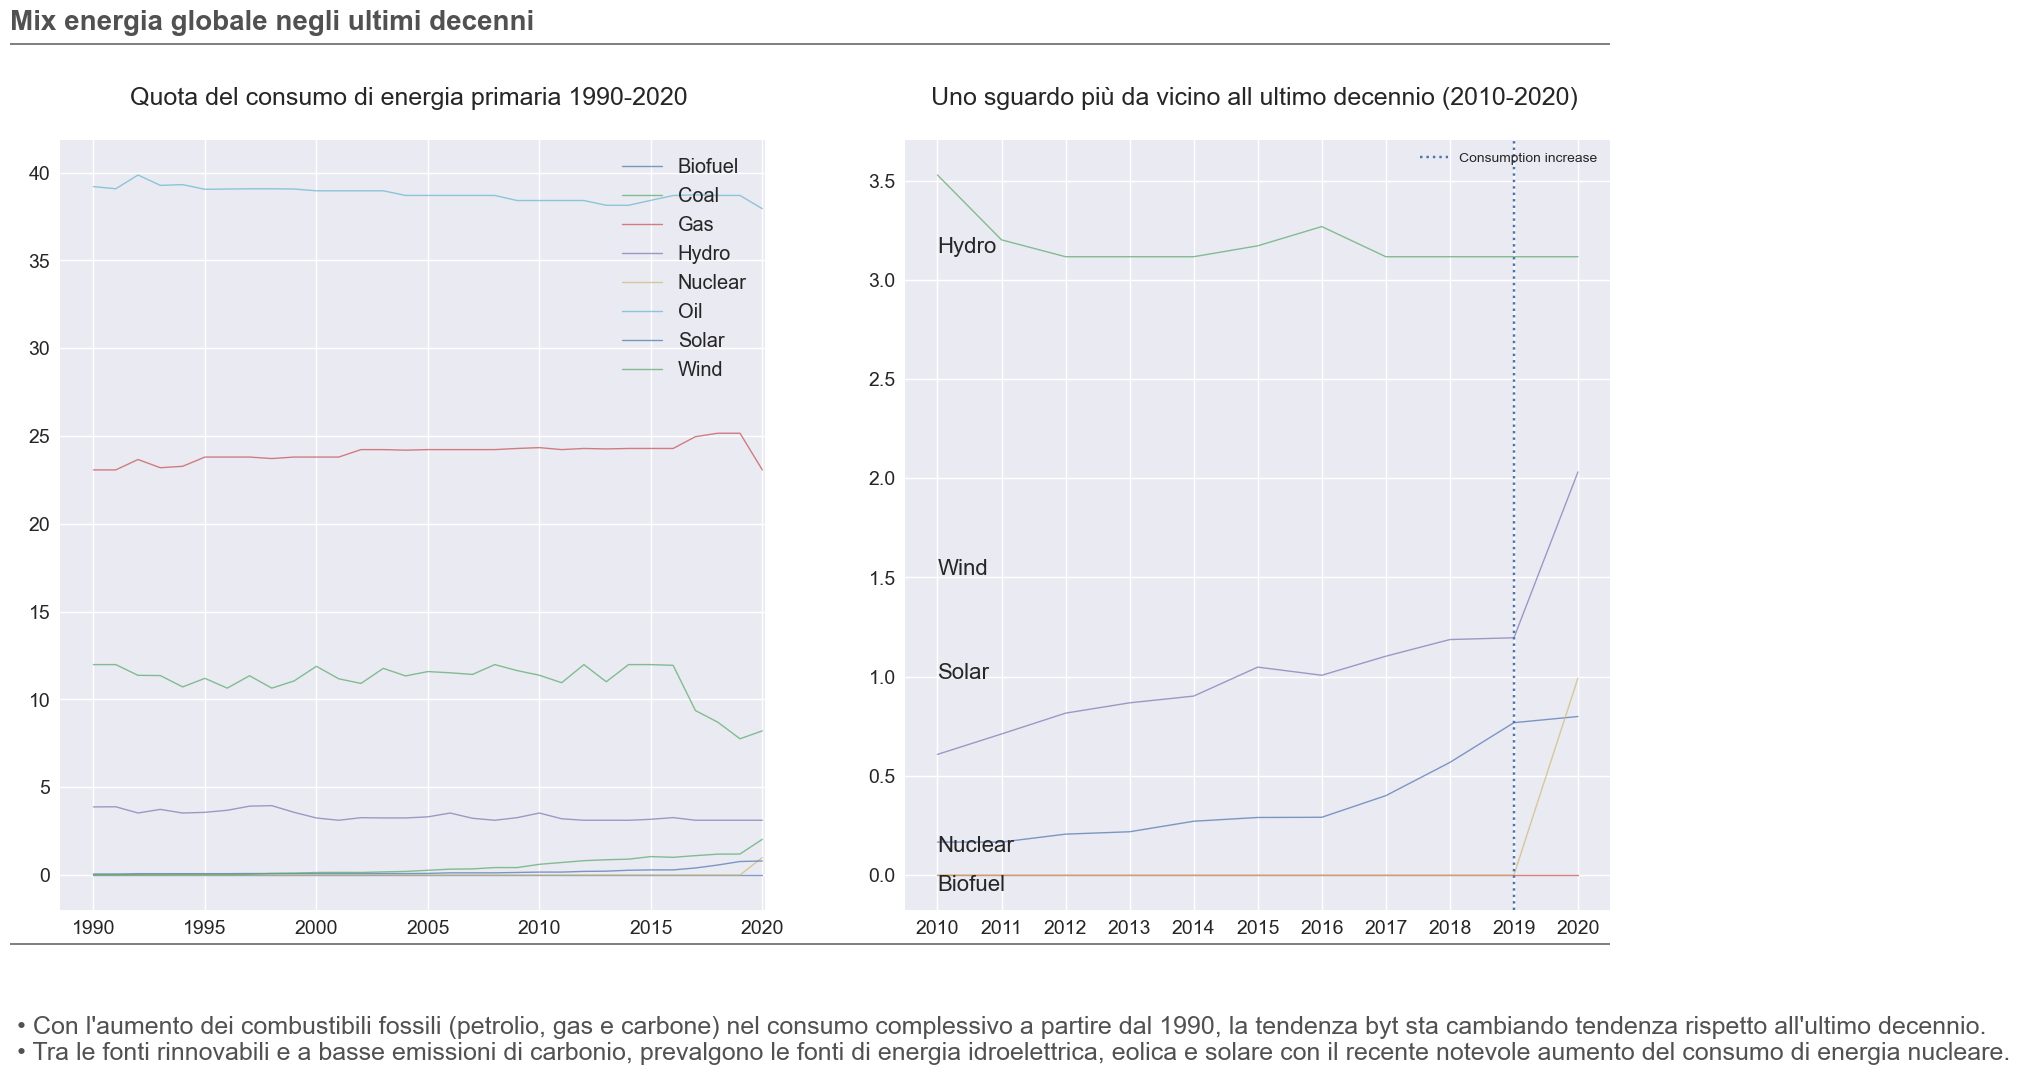

In [329]:
# Copiamo il dataframe in modo tale da avere sempre l'originale
energyDataSetCopied=energyConsumption.copy()
# Estraiamo le colonne che ci interessano usando l'index associato alla colonna (estrazione fatta precedentemente)
energyDataSetCopied=energyDataSetCopied.iloc[:, [1,2, 14, 21, 44, 52, 61, 70, 76, 83, 109, 117]]

# Filtriamo per anno
energyDataSetCopied=energyDataSetCopied[(energyDataSetCopied['year'] >= 1990) & (energyDataSetCopied['year'] <= 2020)]

# Visto che vogliamo vedere l'andamento dei consumi per anno, è stato scelto di raggruppare per anno inoltre eseguiamo il metodo 
# della mediana per evitare valori anomali
energyDataSetCopied=energyDataSetCopied.groupby(by ='year', axis=0, as_index=False).median()

# Rinominiamo il nome delle colonne d'interesse per una maggior leggibilità
energyDataSetCopied.rename(columns = {'biofuel_share_energy': 'Biofuel', 'coal_share_energy': 'Coal', 'gas_share_energy': 'Gas', 'hydro_share_energy' : 'Hydro', 'nuclear_share_energy' : 'Nuclear', 'oil_share_energy' : 'Oil', 'solar_share_energy' :'Solar', 'wind_share_energy': 'Wind'}, inplace=True)

sources = ['Biofuel', 'Coal', 'Gas', 'Hydro', 'Nuclear', 'Oil', 'Solar', 'Wind']

energyDataSetCopied = pd.melt(energyDataSetCopied, id_vars='year', 
             value_vars=sources, 
             var_name='Energy source', 
             value_name='Share of primary energy consumption')

fig, axes = plt.subplots(1,2, figsize=(20, 10))
sns.set_style(style='darkgrid')

# Creo il primo grafico con i dati dal 1990 al 2020

for i in sources:
    axes[0].plot(energyDataSetCopied[energyDataSetCopied['Energy source'] == i]['year'], 
            energyDataSetCopied[energyDataSetCopied['Energy source'] == i]['Share of primary energy consumption'], 
            alpha =0.7, 
            linewidth =1, 
            fillstyle='full')


# Secondo grafico con i dati dell'ultimo decennio (del dataset) con uno sguardo più attento esclusivamente alle fonti rinnovabili e a basse emissioni di carbonio

rlcsources = ['Solar',  'Hydro',  'Biofuel', 'Wind', 'Nuclear']

dataSet=energyDataSetCopied[(energyDataSetCopied['year'] >= 2010)&(energyDataSetCopied['year']<=2020)]  
dataSet.rename(columns = {'biofuel_share_energy': 'Biofuel', 'coal_share_energy': 'Coal', 'gas_share_energy': 'Gas', 'hydro_share_energy' : 'Hydro', 'nuclear_share_energy' : 'Nuclear', 'oil_share_energy' : 'Oil', 'solar_share_energy' :'Solar', 'wind_share_energy': 'Wind'}, inplace=True)

dataSet= dataSet[dataSet['Energy source'].isin(rlcsources)]

for j in rlcsources:
    axes[1].plot(dataSet[dataSet['Energy source'] == j]['year'], 
            dataSet[dataSet['Energy source'] == j]['Share of primary energy consumption'], 
            alpha=0.7, 
            linewidth=1)

year_start, year_end = 2010, 2020
names = dataSet[['Energy source', 'Share of primary energy consumption']][dataSet['year'] == year_end -1]

ad=0
for i, value in names.itertuples(index=False):
    axes[1].text(x=year_start, y=value + ad, s=i, va="top", size=16)
    ad+=0.1
    
# Impostazioni generali del grafico

axes[0].set_title('Quota del consumo di energia primaria 1990-2020 \n', size=18)
axes[1].set_title('Uno sguardo più da vicino all ultimo decennio (2010-2020) \n', size=18)
axes[0].spines[['top','right','left']].set_visible(False)

axes[1].set_xticks(np.arange(year_start, year_end +1))
axes[0].set_xlim([None, year_end + 0.1])

axes[0].legend(sources, loc='upper right', fontsize='x-large')
axes[1].legend(rlcsources, loc='upper right', fontsize='x-large')

axes[0].text(x=0.1, y=0.99, s="Mix energia globale negli ultimi decenni", transform=fig.transFigure, ha='left', fontsize=20, weight='bold', alpha=.8)
axes[0].add_patch(plt.Rectangle((0.1,0.075),              
                           0.8,                     
                           0.002,                      
                           facecolor='grey', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))

axes[0].add_patch(plt.Rectangle((0.1,0.975),              
                           0.8,                     
                           0.002,                      
                           facecolor='grey', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))

axes[0].text(x=0.1, y=-0.04, s=" • Con l'aumento dei combustibili fossili (petrolio, gas e carbone) nel consumo complessivo a partire dal 1990, la tendenza byt sta cambiando tendenza rispetto all'ultimo decennio.\n • Tra le fonti rinnovabili e a basse emissioni di carbonio, prevalgono le fonti di energia idroelettrica, eolica e solare con il recente notevole aumento del consumo di energia nucleare.", 
             transform=fig.transFigure, 
             ha='left', 
             fontsize=18, alpha=.8)

axes[0].xaxis.set_tick_params(labelsize=14) 
axes[1].xaxis.set_tick_params(labelsize=14) 
axes[0].yaxis.set_tick_params(labelsize=14) 
axes[1].yaxis.set_tick_params(labelsize=14) 

plt.axvline(x=2019, linestyle='dotted', label='Consumption increase')
plt.legend(loc = 'upper right')
plt.show()

Mostriamo i cambiamenti storici dei vari consumi energetici mondiali tramite un grafico animato

In [330]:
# Ci concentreremo sulle colonne con i dati sulla variazione della percentuale del consumo di fonti energetiche annua
# a partire dall'anno 1990

consumption=energyConsumption.copy()

consumption=consumption.iloc[:, [1, 2, 9, 13, 20, 43, 51, 60, 69, 75, 82, 108, 106, 92, 98, 114, 102, 41-42]]
consumption=consumption[consumption['year']>=1990]

regions=['World', 'Europe', 'Europe (other)','North America', 'Central America', 'South & Central America', 'CIS',  'South Africa', 'Eastern Africa', 'Other regions', 'Asia Pacific', 'Middle East']

consumption=consumption[consumption['country'].isin(regions)]

fig = px.bar(consumption, 
             x='country', y='energy_cons_change_pct', 
             color='country',
             animation_frame='year', 
             animation_group="country",
             range_y=[-15, 15], 
             labels={'energy_cons_change_pct': 'Energy consumption change, %'}, 
             title='Cambiamenti regionali nel consumo di energia dal 1990, %')

fig.add_vrect(x0=11.5, x1=10.5)
plt.tight_layout()
fig.show()

<Figure size 800x550 with 0 Axes>

Andiamo a costruire il grafico storico mondiale sul consumo di energia pro capite

In [331]:
df=energyConsumption.copy()

filt=df['year']>1970
w=df[filt].groupby('country').get_group('World')

# Mostriamo i 10 record con il valore più basso per quanto riguarda il consumo generale di energia
w.nsmallest(10, ['energy_cons_change_pct', 'fossil_cons_change_pct'])


,iso_code,country,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,...,solar_energy_per_capita,gdp,wind_share_elec,wind_cons_change_pct,wind_share_energy,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_energy_per_capita,gdp_per_capita
17013,OWID_WRL,World,2009,-0.04,-16.26,-3.12,-944.24,-2.51,"-1,166.64",-1.51,...,8.01,"82,400,000,000,000.00",1.43,24.34,0.54,141.75,724.21,40.40,105.37,"11,989.35"
16984,OWID_WRL,World,1980,10.21,0.00,1.32,185.50,-4.52,"-1,700.69",-0.70,...,0.00,"33,100,000,000,000.00",0.00,75.00,0.00,0.01,0.03,0.00,0.01,"7,424.85"
16986,OWID_WRL,World,1982,3.52,755.45,0.46,66.29,-3.96,"-1,337.78",-0.61,...,0.00,"33,500,000,000,000.00",0.00,76.19,0.00,0.02,0.05,0.00,0.01,"7,255.19"
16985,OWID_WRL,World,1981,10.21,0.00,1.72,245.86,-5.76,"-2,068.39",-0.47,...,0.00,"33,400,000,000,000.00",0.00,0.00,0.00,0.00,0.03,0.00,0.01,"7,361.70"
16978,OWID_WRL,World,1974,10.21,0.00,2.09,240.47,0.22,74.43,0.54,...,0.00,"26,700,000,000,000.00",0.00,57.66,0.00,0.00,0.00,0.00,0.00,"6,668.67"
16979,OWID_WRL,World,1975,10.21,0.00,0.26,30.09,-5.02,"-1,679.18",0.54,...,0.00,"27,300,000,000,000.00",0.00,57.66,0.00,0.00,0.00,0.00,0.00,"6,692.03"
17002,OWID_WRL,World,1998,-1.80,-483.66,2.62,573.52,2.53,"1,010.16",0.62,...,0.39,"52,100,000,000,000.00",0.11,32.48,0.04,10.84,44.23,2.66,7.39,"8,705.40"
16997,OWID_WRL,World,1993,-3.01,-770.49,1.16,232.34,-0.14,-52.74,0.70,...,0.28,"45,400,000,000,000.00",0.04,20.37,0.02,2.68,15.83,1.02,2.83,"8,133.87"
16995,OWID_WRL,World,1991,-2.72,-715.70,1.31,258.60,-0.27,-98.92,0.70,...,0.26,"43,700,000,000,000.00",0.03,12.51,0.01,1.26,11.35,0.76,2.10,"8,071.24"
17019,OWID_WRL,World,2015,-2.63,"-1,215.34",2.18,747.30,3.12,"1,534.11",0.73,...,88.04,"105,000,000,000,000.00",3.55,17.01,1.39,305.77,"2,103.67",112.29,285.06,"14,228.03"


Osservando il grafico possiamo vedere che i livelli di consumo generale di energia sono diminuiti significativamente durante crisi globali ben note come la crisi energetica negli anni 1970-80, negli anni 2000 e metà degli anni 2010 e durante la pandemia, come vedremo anche più avanti

In [332]:
# Mostriamo i 10 record con il valore più alto per quanto riguarda il consumo di energia rinnovabile
w.nlargest(10, ['low_carbon_energy_per_capita','renewables_energy_per_capita'])

,iso_code,country,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,...,solar_energy_per_capita,gdp,wind_share_elec,wind_cons_change_pct,wind_share_energy,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_energy_per_capita,gdp_per_capita
17023,OWID_WRL,World,2019,1.52,698.28,3.42,"1,318.30",-0.33,-174.65,1.33,...,232.45,"107,000,000,000,000.00",5.47,12.14,2.18,383.21,"3,540.05",183.70,458.94,"13,871.84"
17024,OWID_WRL,World,2020,1.52,698.28,3.42,"1,318.30",-0.33,-174.65,1.33,...,232.45,"107,000,000,000,000.00",6.15,12.14,2.18,383.21,"3,540.05",204.01,458.94,"13,871.84"
17022,OWID_WRL,World,2018,5.03,"2,195.18",5.04,"1,849.83",2.41,"1,231.38",2.82,...,189.80,"107,000,000,000,000.00",4.95,10.67,1.97,304.42,"3,156.84",165.91,413.68,"14,021.59"
17021,OWID_WRL,World,2017,2.52,"1,071.37",3.73,"1,321.64",0.33,169.82,1.78,...,148.04,"107,000,000,000,000.00",4.62,17.69,1.83,428.74,"2,852.43",150.38,377.91,"14,176.21"
17020,OWID_WRL,World,2016,-5.18,"-2,326.87",1.14,397.18,0.37,185.18,1.37,...,110.59,"107,000,000,000,000.00",4.01,15.21,1.58,320.02,"2,423.69",128.47,324.72,"14,335.43"
17019,OWID_WRL,World,2015,-2.63,"-1,215.34",2.18,747.30,3.12,"1,534.11",0.73,...,88.04,"105,000,000,000,000.00",3.55,17.01,1.39,305.77,"2,103.67",112.29,285.06,"14,228.03"
17018,OWID_WRL,World,2014,-0.35,-163.00,2.03,680.63,2.32,"1,113.37",0.81,...,69.02,"102,000,000,000,000.00",3.14,10.45,1.20,170.17,"1,797.90",98.78,246.45,"13,981.62"
17017,OWID_WRL,World,2013,1.80,816.93,1.17,389.40,0.21,100.22,1.89,...,49.40,"99,300,000,000,000.00",2.85,19.04,1.09,260.39,"1,627.74",89.21,225.74,"13,771.43"
17014,OWID_WRL,World,2010,5.55,"2,203.03",7.20,"2,112.97",2.01,912.84,4.81,...,12.64,"88,500,000,000,000.00",1.67,24.75,0.64,179.25,903.47,49.80,129.87,"12,721.32"
17016,OWID_WRL,World,2012,1.15,515.76,2.06,669.60,2.79,"1,299.15",1.29,...,36.44,"96,600,000,000,000.00",2.42,19.75,0.94,225.50,"1,367.35",74.59,191.89,"13,556.32"


Dal grafico è interessenta notare che il consumo di energia rinnovabile e a basso consumo di carbonio è in aumento nell'ultimo decennio

Ora, concentriamoci sui modelli di consumo energetico pro capite visualizzando i modelli relativi alle variazioni del PIL e del consumo energetico

In [333]:
regions=['World', 'Europe', 'Europe (other)','North America', 'Central America', 'South & Central America', 'CIS',  'South Africa', 'Eastern Africa', 'Other regions', 'Asia Pacific', 'Middle East']

wemc=energyConsumption.copy()
wemc=wemc[(wemc['year']>=1990)]
wemc=wemc.loc[wemc['country'].isin(regions)]
wemc=wemc.iloc[:, [1, 2, 42, 47, 98, 99, 122]]

px.scatter(wemc, x='population', y='primary_energy_consumption', 
           animation_frame="year", 
           animation_group="country",
           size='gdp_per_capita', 
           color="country", 
           hover_name="country",      
           size_max=55, 
           log_x=True,
           range_y=[-100, 100000],
           title='Consumo di energia primaria vs crescita della popolazione <br><sup>L Asia-Pacifico, con il più alto PIL pro capite, sta aumentando significativamente il suo consumo di energia primaria</sup>', 
           labels={'primary_energy_consumption': 'Consumo di energia, kw/hrs', 'population': 'Popolazione'})

Dal grafico sopra possiamo vedere che il più alto livello di PIL in Asia-Pacifico è correlato con l'aumento del consumo di energia nel corso degli anni.

Osserviamo la correlazione tra dati principali come il PIL pro capite/dimensioni della popolazione/consumo energetico ecc.

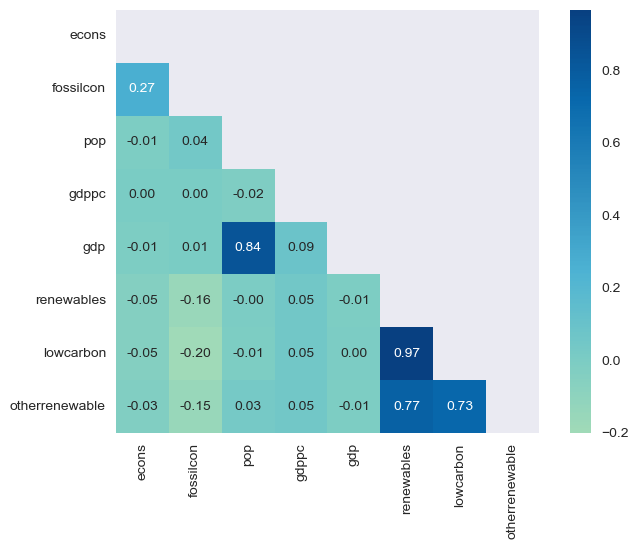

In [334]:
wo=energyConsumption.copy()
filt=wo['year']>1970
wo=wo[filt]
wo.drop_duplicates()

wo=wo[wo['country'].isin(regions)]

wo=pd.DataFrame().assign(
    country=energyConsumption['country'], 
    econs=energyConsumption['energy_cons_change_pct'], 
    fossilcon=energyConsumption['fossil_cons_change_pct'], 
    pop=energyConsumption['population'], 
    gdppc=energyConsumption['gdp_per_capita'],
    gdp=energyConsumption['gdp'],
    renewables=energyConsumption['renewables_energy_per_capita'],
    lowcarbon=energyConsumption['low_carbon_energy_per_capita'],
    otherrenewable=energyConsumption['other_renewables_energy_per_capita'])

# La funzione .corr() ci permette di trovare la correlazione a coppie di tutte le colonne presente nel dataframe
c=wo.corr()

# Creiamo una maschera
mask=np.triu(np.ones_like(c, dtype=bool))
sns.heatmap(c, mask=mask, center=0, annot=True, fmt='.2f', square=True, cmap="GnBu")

plt.show()

Dal grafico qui di seguito possiamo dedurre diverse considerazioni:

-Il consumo di energie rinnovabili e le fonti energetiche a basse emissioni di carbonio sono fortemente correlati.
-C'è una piccola correlazione positiva (0,26) tra il consumo di energia e il consumo di combustibili fossili, il che significa l'aumento del consumo in particolare dei combustibili fossili
-Nessuna correlazione trovata tra il PIL pro capite e il consumo di energia da fonti rinnovabili.



# Profilo del consumo di energia dei paesi con le più alte emissioni di gas serra

Carichiamo i dati sulle emissioni di gas serra dal dataset preso su Climate Watch

In [335]:
# https://www.climatewatchdata.org/ghg-emissions?end_year=2019&start_year=1990
ghg=pd.read_csv('./datasets/ghg-emissions.csv')

ghg.isna().sum()
ghg=ghg.fillna(method='ffill').fillna(method='bfill')

Adesso avremo bisogno di trovare i primi dieci paesi con il maggior livello di emissioni di gas serra

In [336]:
ghg=pd.melt(ghg, id_vars='Country/Region', 
            value_vars=['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], 
            value_name='ghg', 
            var_name='year', 
            ignore_index=False)

# Concentriamoci sull'ultimo decennio poiché esattamente allora il consumo di energie rinnovabili a basse emissioni di carbonio ha iniziato ad aumentare.

ghg=ghg[ghg['year']>='2010']

# Calcoliamo il valore mediano delle emissioni di gas serra negli ultimi 10 anni per tutti i paesi per fare un confronto

medianghg = ghg.ghg.median()

medianghg

37.625

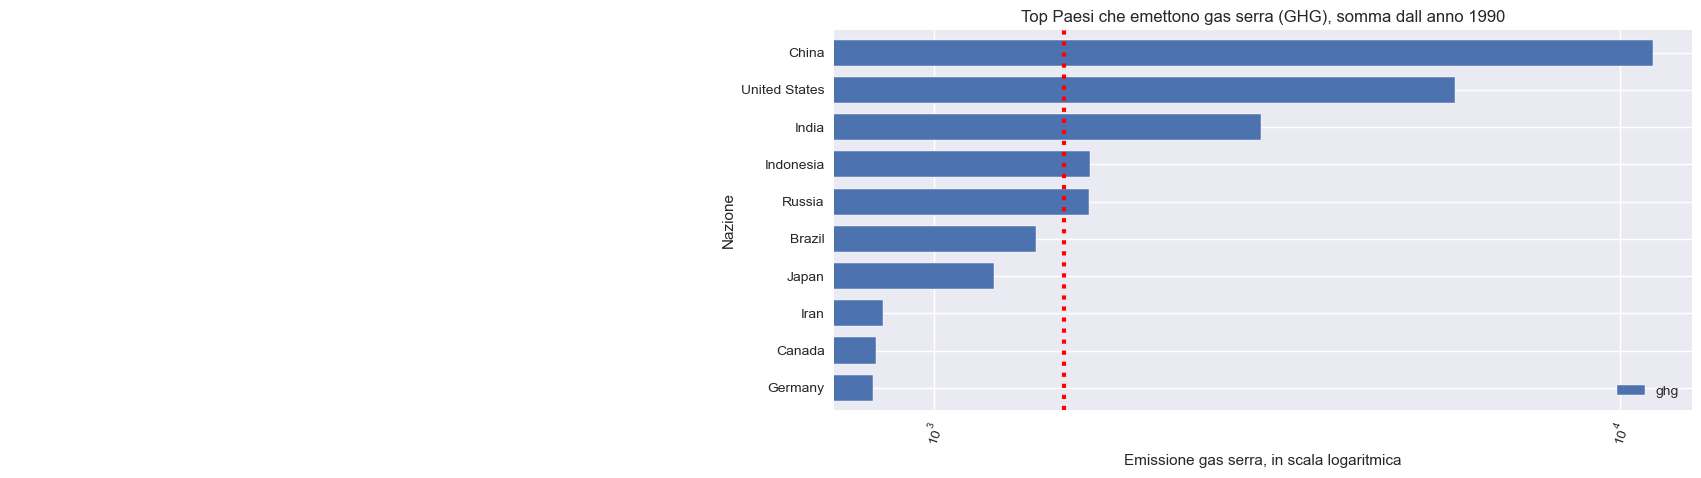

In [337]:
# Prendiamo i primi 10 paesi con la maggiore quantità di emissioni di gas serra:

topghg=ghg.groupby('Country/Region', as_index=False).agg({'ghg': 'median'}).sort_values('ghg', ascending=False).head(10)
topghg.sort_values('ghg', ascending=False)


# Selezione dei principali paesi con le più alte emissioni di gas serra dall'elenco del consumo mondiale di energia
topRegionsGhG=[]
for c in topghg['Country/Region']:
    if c not in topRegionsGhG:
        topRegionsGhG.append(c)
        
ctbarh=topghg[topghg['Country/Region'].isin(topRegionsGhG)].sort_values(by='ghg')

plt.style.use('seaborn')
ctbarh.plot.barh(x='Country/Region', y='ghg', width=0.7, figsize=(10,5))

plt.title('Top Paesi che emettono gas serra (GHG), somma dall anno 1990')
plt.ylabel('Nazione')
plt.xlabel('Emissione gas serra, in scala logaritmica')
plt.xticks(rotation=70)
plt.axvline(x=topghg.ghg.median(), linestyle='dotted',color='red', linewidth=3)
plt.text(x=45, y=7.9, s='Valore mediano globale di GHG su 10 anni', color='white')
plt.tight_layout()
plt.xscale('log')
plt.show()

In [338]:

ct=ghg[ghg['Country/Region'].isin(t)]

fig = px.bar(ct, x='Country/Region', y='ghg', color='Country/Region',
             animation_frame="year", 
             animation_group="Country/Region", 
             range_y=[0, 13000], 
             title=('Emissioni totali di gas serra, CO2e: i primi 10 emettitori'),
             labels={'ghg': 'Emissioni di gas serra (ghg)', 'gdp_per_capita': 'PIL pro capite', 'Country/Region': 'Nazione'})
plt.tight_layout()                
fig.show()

<Figure size 800x550 with 0 Axes>

Come possiamo vedere Cina e Stati Uniti sono in testa alla classifica con i più alti livelli di emissioni di gas serra.
Ora andremo ad analizzare i profili di consumo pro capite per ciascuna regione analizzata

In [340]:

consumptionpersource=energyConsumption.copy()
consumptionpersource=consumptionpersource.iloc[:, [1, 2, 17, 25, 56, 65, 73, 80, 87, 96, 106, 113, 121]]
consumptionpersource=consumptionpersource.fillna(method='ffill').fillna(method='bfill')
consumptionpersource=consumptionpersource[consumptionpersource['year']>=2000]
consumptionpersource['year']=pd.to_datetime(consumptionpersource['year'], format='%Y')
consumptionpersource['year']=consumptionpersource['year'].dt.year
consumptionpersource=consumptionpersource[consumptionpersource['country'].isin(t)]

fig = px.bar(consumptionpersource, 
             x="country", y=['other_renewables_energy_per_capita', 'oil_energy_per_capita', 'nuclear_energy_per_capita', 'hydro_energy_per_capita',
                             'gas_energy_per_capita','coal_cons_per_capita', 'biofuel_cons_per_capita','solar_energy_per_capita', 'wind_energy_per_capita'], 
             title="Profili di consumo pro capite, maggiori emettitori",
             color_discrete_map={
                'coal_cons_per_capita':'black',
                'gas_energy_per_capita': '#F0F8FF',
                'oil_energy_per_capita': "#B8860B",
                'nuclear_energy_per_capita': "#E0EEEE",
                'hydro_energy_per_capita': "#00FFFF",
                'biofuel_cons_per_capita': '#228B22',
                'solar_energy_per_capita': '#FFFF00', 
                'wind_energy_per_capita':'#F8F8FF',
                'other_renewables_energy_per_capita': "magenta"}, 
             animation_frame="year", 
             animation_group="country",                         
             range_y=[0, 200000])
plt.tight_layout()
fig.show()


<Figure size 800x550 with 0 Axes>

# Profili di consumo energetico per i Paesi con le migliori Smart Cities: focus su Rinnovabili

Importo l'elenco delle Smart Cities dal set di dati "IMD Smart City Index 2020 report.csv" da unire ai dati sul consumo energetico mondiale. 

In [341]:
# https://blog.threeandahalfroses.com/2020/11/30/the-imd-smart-city-index-2020-report-with-excel-download/
smartCities=pd.read_csv('./datasets/IMD Smart City Index 2020 report.csv')


# Assegniamo degli index alle colonne per poterle analizzare separatamente

x=-1
for column in smartCities.columns:
    x+=1
    print(x, column)


0 City
1 Ranking
2 Change
3 Smart City Rating 2020
4 Smart City Rank 2019
5 Smart City Rating 2019
6 Country
7 Continent
8 Population


In [342]:
# Estraiamo le colonne "city", "ranking", "country"
smartCities=smartCities.iloc[:, [0,1, 6]]

# Verifico se ci sono valori null
smartCities.isnull().sum()

City       0
Ranking    0
Country    0
dtype: int64

Dobbiamo verificare se l'ortografia dei nomi dei paesi è la stessa in entrambi gli elenchi confrontandoli:

In [343]:
countries=[]

# Prepariamo un elenco di paesi presenti nel dataset Smart Cities
for country in smartCities['Country']:
    if country not in countries: 
        countries.append(country)

# Prepariamo un elenco di paesi dal set di dati "World Energy" per confrontare i nomi dei paesi      
energyConsumption.groupby('country')

countriesall=[]
for country in energyConsumption['country']:
    if country not in countriesall: 
        countriesall.append(country)

        
# Troviamo l'elenco dei paesi mancanti nel dataset "IMD Smart City" a causa della differenza di ortografia, quindi andremo a sostituirli
# con i nomi presenti in "World Enrgy"

comparison=[]
for i in countries:
    if i not in countriesall:
        comparison.append(i)
comparison 

['UAE', 'The Netherlands', 'UK', 'US', 'Singapore ', 'Isreal']

Trovati i paesi mancanti, andiamo a sostituire i nomi nel dataframe Smart Cities con quelli nel World Energy in modo da poter  selezionare i paesi da entrambi i set di dati:

In [344]:
# Guardiamo i paesi presenti in World Energy per sapere "UAE", "The Netherlands" e via dicendo a cosa corrispondono
countriesall

['Afghanistan',
 'Africa',
 'Albania',
 'Algeria',
 'American Samoa',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Asia Pacific',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'CIS',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Central America',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Cook Islands',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Czechoslovakia',
 'Democratic Republic of Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Eastern Africa',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Europe',

In [345]:
# Sostituiamo i nomi
smartCities['Country'].replace('UAE', 'United Arab Emirates', inplace=True)
smartCities['Country'].replace('The Netherlands', 'Netherlands', inplace=True)
smartCities['Country'].replace('UK', 'United Kingdom', inplace=True)
smartCities['Country'].replace('US', 'United States', inplace=True)
smartCities['Country'].replace('Singapore ', 'Singapore', inplace=True)
smartCities['Country'].replace('Isreal', 'Israel', inplace=True)   

# Ordiniamo i valori per graduatoria
temp = smartCities.sort_values('Ranking', ascending=True)

# Aggiungiamo i primi 10 paesi scorrendo l'elenco delle classifiche per le smart cities
topsmartcountries=[]
x=0
for country in temp.Country:
    if country not in topsmartcountries and x<10:
        x+=1
        topsmartcountries.append(country)
topsmartcountries

['Singapore',
 'Finland',
 'Switzerland',
 'New Zealand',
 'Norway',
 'Denmark',
 'China',
 'Netherlands',
 'United States',
 'Germany']

In [346]:
ec=energyConsumption.copy()
# Estraiamo i paesi dal dataframe "World Energy" in base alla lista creata prima
ec=ec.loc[ec['country'].isin(topsmartcountries)]
ec=ec.iloc[:, [1, 2,  73, 96, 98, 114, 106,  121]]
ec=ec[ec['year']>=2000]

# Calcoliamo il consumo pro capite totale di energia rinnovabile a basse emissioni di carbonio

ec['renewlowcarbon']=ec['low_carbon_energy_per_capita']+ec['other_renewables_energy_per_capita']+ec['renewables_energy_per_capita']
ec['gdp_per_capita']=ec['gdp']/ec['population']

px.scatter(sc, x='renewlowcarbon', y='gdp_per_capita', 
           animation_frame="year", animation_group="country",
           size='population', 
           color="country", 
           hover_name="country",
           log_x=True, 
           size_max=55, 
           title='Crescita del consumo di energie rinnovabili nei paesi con Smart Cities<br><sup>Crescita notevole delle energie rinnovabili e del consumo di energia a basse emissioni di carbonio nell ultimo decennio nei paesi con le Smart Cities<br>più performanti</sup>',
           labels={'renewlowcarbon': 'Consumo di energia rinnovabile a basse emissioni di carbonio, pro capite', 'gdp_per_capita': 'GDP pro capite'})

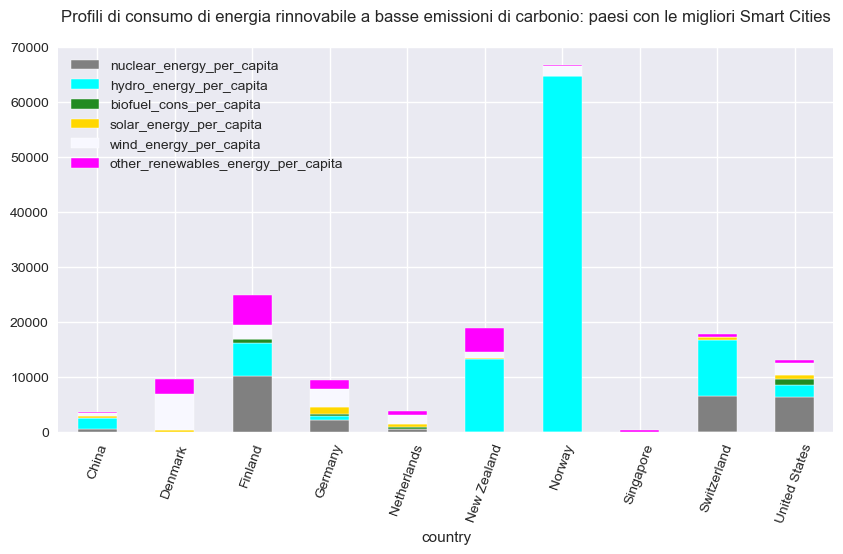

In [347]:
# Diamo un'occhiata al profilo del "mix" di energia rinnovabile a bassa emissione di carbonio per quei paesi a partire dal 2015

ec=energyConsumption.copy()
ec=ec.iloc[:, [1, 2, 17, 25, 56, 65, 73, 80, 87, 96, 106, 113, 121]]
ec=ec[ec['year']>2015]
ec=ec[ec['country'].isin(topsmartcountries)]

sns.set_style(style='darkgrid')

ec=ec.groupby('country', as_index=False).median().groupby('country', as_index=False).mean()
ec.plot(x='country', 
          y=['nuclear_energy_per_capita', 'hydro_energy_per_capita', 'biofuel_cons_per_capita', 'solar_energy_per_capita', 'wind_energy_per_capita', 'other_renewables_energy_per_capita'], 
          kind='bar', 
         stacked=True,
          figsize=(10, 5), 
          title='Profili di consumo di energia rinnovabile a basse emissioni di carbonio: paesi con le migliori Smart Cities\n', 
          color={'coal_cons_per_capita':'black',
                'gas_energy_per_capita': '#F0F8FF',
                'oil_energy_per_capita': "#FFB90F",
                'nuclear_energy_per_capita': "grey",
                'hydro_energy_per_capita': "#00FFFF",
                'biofuel_cons_per_capita': '#228B22',
                'solar_energy_per_capita': '#FFD700', 
                'wind_energy_per_capita':'#F8F8FF',
                'other_renewables_energy_per_capita': "magenta"})
plt.xticks(rotation=70)
plt.show()

In [348]:
fig = px.bar(scr, x="country",
             y=['other_renewables_energy_per_capita', 'oil_energy_per_capita', 'nuclear_energy_per_capita', 'hydro_energy_per_capita','gas_energy_per_capita','coal_cons_per_capita', 'biofuel_cons_per_capita','renewables_energy_per_capita', 'solar_energy_per_capita', 'wind_energy_per_capita'], 
             title="Prospettiva storica sulle energie rinnovabili e sui profili di consumo a basse emissioni di carbonio <br><sup>Paesi con i migliori risultati di Smart Cities, pro capite</sup>",
            color_discrete_map={
                'coal_cons_per_capita':'black',
                'gas_energy_per_capita': '#F0F8FF',
                'oil_energy_per_capita': "#FFB90F",
                'nuclear_energy_per_capita': "#E0EEEE",
                'hydro_energy_per_capita': "#00FFFF",
                'biofuel_cons_per_capita': '#228B22',
                'solar_energy_per_capita': '#FFD700', 
                'wind_energy_per_capita':'#F8F8FF',
                'renewables_energy_per_capita':'#CAFF70',
                'other_renewables_energy_per_capita': "magenta"}, 
             animation_frame="year", 
             animation_group="country",
            range_y=[0, 200000])
plt.tight_layout()
fig.show()

<Figure size 800x550 with 0 Axes>

In [349]:
wec=energyConsumption[(energyConsumption['year']>=2010)&(energyConsumption['year']<=2020)]

wec= wec[wec["country"].isin(topsmartcountries)]
wec = wec.fillna(method="ffill").fillna(method="bfill")

wec['renlowcarbon'] = wec['other_renewables_energy_per_capita']+ wec['renewables_energy_per_capita']+ wec['low_carbon_energy_per_capita']

medianrenew = wec['renlowcarbon'].mean()

wec.groupby('country').median().sort_values(by=['renlowcarbon'], ascending=False).head(10)

,year,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,energy_cons_change_pct,energy_cons_change_twh,biofuel_share_elec,...,gdp,wind_share_elec,wind_cons_change_pct,wind_share_energy,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_energy_per_capita,gdp_per_capita,renlowcarbon
country,,,,,,,,,,,,,,,,,,,,,
Norway,"2,015.00",0.00,0.50,-0.30,-3.48,-5.31,-55.48,0.40,2.11,0.33,...,"400,000,000,000.00",1.58,20.78,1.09,0.83,5.64,430.77,"1,097.25","75,845.97","133,403.91"
Finland,"2,015.00",-21.12,0.00,-12.94,-10.95,-3.03,-5.36,-3.19,-10.70,16.82,...,"210,000,000,000.00",3.40,31.04,1.84,0.71,5.89,424.62,"1,074.21","38,141.72","44,356.00"
New Zealand,"2,015.00",-5.84,-1.31,-13.03,-42.07,0.00,0.64,0.96,2.35,1.42,...,"153,000,000,000.00",4.81,6.28,2.19,0.35,5.36,460.61,"1,167.55","33,152.76","42,698.46"
Switzerland,"2,015.00",0.00,-0.11,0.00,0.00,0.00,0.02,0.19,0.59,4.38,...,"518,000,000,000.00",0.17,8.26,0.09,0.02,0.27,13.01,32.71,"61,813.19","31,569.21"
United States,"2,015.00",-3.27,-188.10,5.15,355.77,11.18,568.49,-0.14,-36.45,1.47,...,"16,900,000,000,000.00",4.66,11.37,1.90,65.29,487.35,594.37,"1,518.79","52,269.31","18,518.07"
Denmark,"2,015.00",0.00,-0.81,-12.63,-7.57,-9.95,-8.67,-0.50,-0.98,14.48,...,"255,000,000,000.00",41.85,14.95,16.54,2.73,33.28,"2,309.06","5,876.35","44,823.34","18,418.86"
Germany,"2,015.00",-2.99,-15.37,-7.90,-6.01,0.00,3.66,1.21,45.63,7.85,...,"3,850,000,000,000.00",12.41,10.26,5.31,13.85,200.99,973.31,"2,445.34","46,936.55","16,521.74"
Netherlands,"2,015.00",0.00,-0.24,-13.00,-42.07,0.00,0.64,-0.42,-4.15,4.86,...,"821,000,000,000.00",6.85,8.06,1.96,1.57,19.10,445.74,"1,127.61","48,503.92","6,025.68"
China,"2,015.00",3.33,654.88,8.27,103.33,1.01,22.15,3.77,"1,251.26",0.94,...,"16,400,000,000,000.00",3.23,25.72,1.35,88.56,469.50,131.93,333.73,"11,657.27","5,449.62"


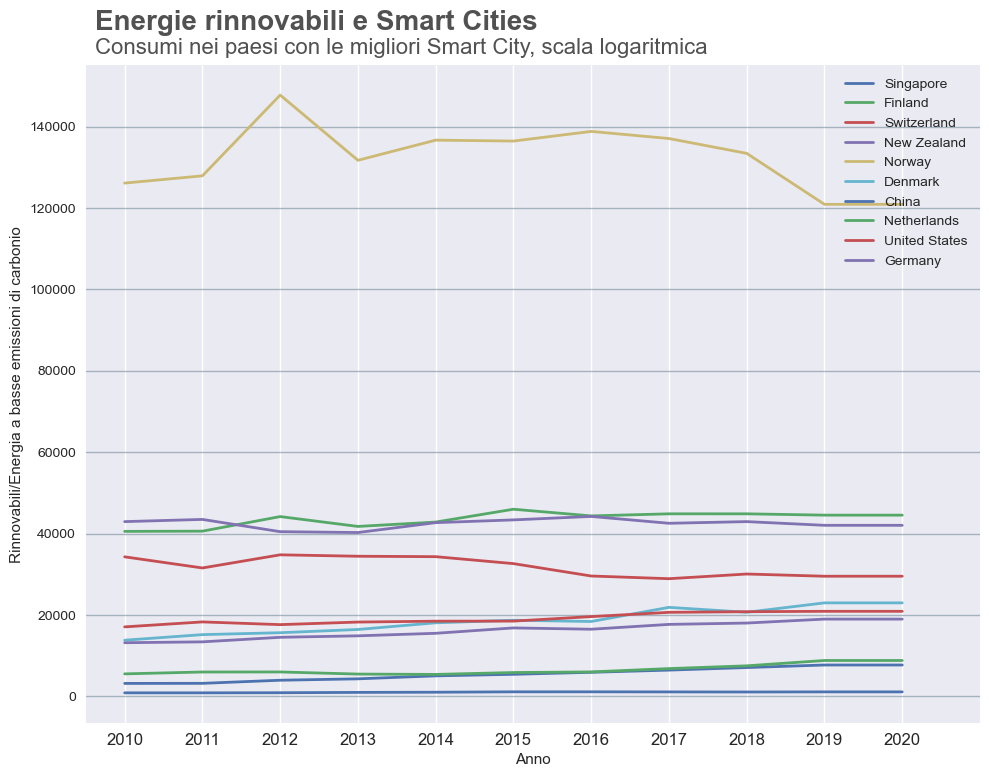

In [350]:
wec=energyConsumption[(energyConsumption['year']>=2010)&(energyConsumption['year']<=2020)]
wec = wec.fillna(method="ffill").fillna(method="bfill")

# Eseguo il calcolo sulle colonne con tutti i numeri di consumo di fonti rinnovabili/basse emissioni di carbonio:
wec['renlowcarbon'] = wec['other_renewables_energy_per_capita']+ wec['renewables_energy_per_capita']+ wec['low_carbon_energy_per_capita']


# Scelgo i paesi che sono nella lista di quelli con Smart Cities

wec= wec[wec["country"].isin(topsmartcountries)]

# Creo il grafico con i paesi con le migliori Smart Cities

column='renlowcarbon'

fig, ax = plt.subplots(figsize=(10,8))

sns.set_style(style='darkgrid')

ax.grid(which="major", axis='y', color='#758D99', alpha=0.6, zorder=1)

for region in topsmartcountries:
    ax.plot(wec[wec['country'] == region]['year'], 
            wec[wec['country'] == region]['renlowcarbon'], 
            alpha=1, 
            linewidth=2)
       
ax.plot(wec[wec['country'] == 'World']['year'], 
        wec[wec['country'] == 'World']['renlowcarbon'], 
        color='grey',
        linewidth=3)

year_start, year_end = 2010, 2020

labels = wec[['country', column]][wec['year'] == year_end-1]

# add=0
# for region, value in labels.itertuples(index=False):
   # ax.text(x=year_start, y=value +add, s=region, va="center")
   # add=-1

ax.spines[['top','right','left', 'bottom']].set_visible(False)

ax.set_xticks(np.arange(year_start, year_end +.1, 1))
ax.set_xlim([None, year_end + 1])

# Aggiungo titolo e sottotitolo
ax.text(x=0.1, y=0.94, s="Energie rinnovabili e Smart Cities", transform=fig.transFigure, ha='left', fontsize=20, weight='bold', alpha=.8)
ax.text(x=0.1, y=0.91, s="Consumi nei paesi con le migliori Smart City, scala logaritmica", transform=fig.transFigure, ha='left', fontsize=16, alpha=.8)
ax.legend(topsmartcountries, loc='upper right')
plt.xlabel('Anno') 
ax.xaxis.set_tick_params(labelsize=12) 
plt.ylabel('Rinnovabili/Energia a basse emissioni di carbonio')
plt.tight_layout()
plt.show()

# Modelli di produzione di energia

Adesso andremo ad analizzare i profili di produzione di energia da combustibili fossili per i paesi con i più alti livelli di emissioni di gas serra (pro capite) dal 1990

In [374]:
# Sfortunatamente, questo set di dati contiene informazioni sulla produzione di energia principalmente per i combustibili fossili (petrolio, gas e carbone).

p=energyConsumption.copy()

p=p.iloc[:, [1, 2, 27, 58, 89]]
p=p[p['year']>=1990]
p=p.loc[p['country'].isin(topRegionsGhG)]

p['ffprod']=p['coal_prod_per_capita']+p['gas_prod_per_capita']+p['oil_prod_per_capita']

fig = px.bar(p, x="country", y="ffprod", color="country",
  animation_frame="year", animation_group="country", 
             range_y=[0, 320000], 
             labels={"ffprod": "Produzione pro capite di combustibili fossili"}, 
             title='Produzione di energia da combustibili fossili nei principali paesi con le più alte emissioni di gas serra')

fig.show()

NameError: name 'topRegionsGhG' is not defined

Andiamo a visualizzare la produzione di combustibili fossili nei Paesi con le migliori Smart Cities

In [352]:
p=energyConsumption.copy()

p=p.iloc[:, [1, 2, 27, 58, 89]]
p=p[p['year']>=1990]
p=p.loc[p['country'].isin(topsmartcountries)]

p['ffprod']=p['coal_prod_per_capita']+p['gas_prod_per_capita']+p['oil_prod_per_capita']

fig = px.bar(p, x="country", y="ffprod", color="country",
  animation_frame="year", animation_group="country", 
             range_y=[0, 550000], 
             labels={"ffprod": "Produzione pro capite di combustibili fossili"}, 
             title='Produzione di energia da combustibili fossili nei paesi con le migliori smart cities')

fig.show()

# Forecasting della produzione di energia derivante da combustibili fossili

In [393]:
from pandas import to_datetime

df =energyConsumption.copy()
df=df.iloc[:, [1, 2, 27, 58, 89]]
df=df[df['year']>=1970]
df=df.loc[df['country'].isin(["China"])]

df['ffprod']=df['coal_prod_per_capita']+df['gas_prod_per_capita']+df['oil_prod_per_capita']

# Rinominiamo le colonne del dataframe per come se le aspetta il modello, ovvero "ds" e "y"
df = df.rename(columns={"year": "ds", "ffprod": "y"}, errors="raise")

# Convertiamo l'anno in un formato leggibile dal modello (datetime)

#df['ds']= to_datetime(df['ds'])
df['ds'] = df['ds'].astype(str).astype('datetime64')



# Definiamo il modello
model = Prophet()
# Associamo il dataframe al modello
model.fit(df)


21:31:59 - cmdstanpy - INFO - Chain [1] start processing
21:31:59 - cmdstanpy - INFO - Chain [1] done processing


In [394]:
# Creiamo un dataframe con le date future per la previsione (in questo caso settiamo un periodo di predizione a 6 anni)
future = model.make_future_dataframe(periods=6, freq='Y')

In [395]:
# Usiamo il modello per fare una previsione
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
52,2021-12-31,"20,100.02","18,775.33","21,515.60"
53,2022-12-31,"20,325.09","18,950.59","21,735.61"
54,2023-12-31,"20,497.08","19,165.25","21,924.62"
55,2024-12-31,"21,728.70","20,339.27","23,139.66"
56,2025-12-31,"22,007.25","20,579.29","23,422.14"


Come possiamo osservare il risultato della funzione predict() è un DataFrame che contiene diverse colonne. 
Le colonne che interessano a noi sono:
- l anno della data di previsione ("ds"), 
- il valore previsto ("yhat")
- i limiti inferiore e superiore sul valore previsto ("yhat_lower" e "yhat_upper") che forniscono incertezza della previsione.

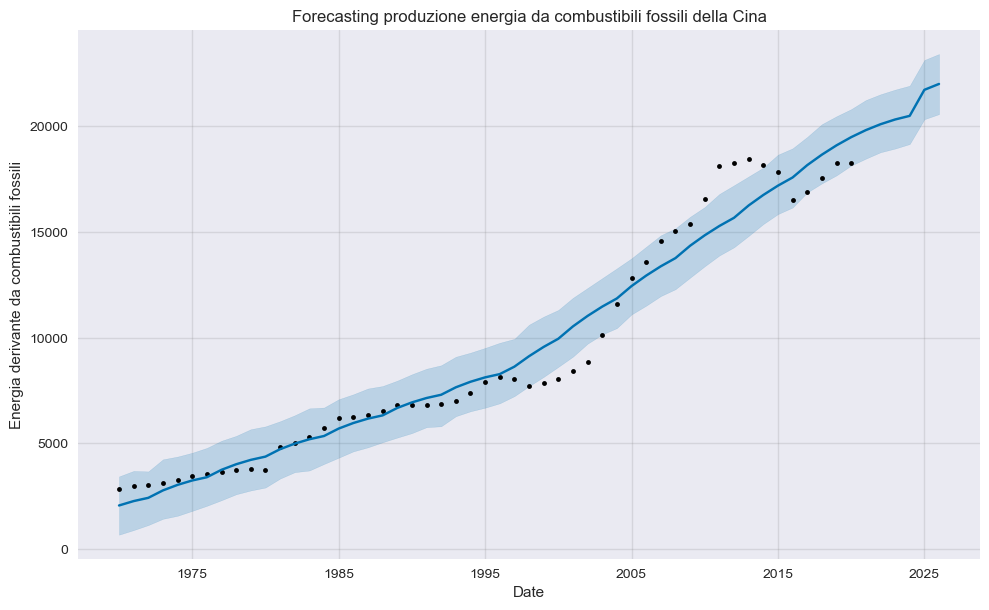

In [396]:

model.plot(forecast, xlabel = 'Date', ylabel = 'Energia derivante da combustibili fossili')
plt.title('Forecasting produzione energia da combustibili fossili della Cina');


Secondo il modello Prophet la Cina andrà a produrre sempre più energia derivante dai combustibili fossili, essendo anche il maggior emettitore di gas serra, si avrà un notevole aumento di inquinamento 

Prophet permette anche di visualizzare i "trend". In questo caso osserviamo che la crescita dell'energia derivante da combustibili fossili ha un andamento molto lineare nel corso degli anni, con un "picco"di crescits a partire intorno l'anno 1995/2000

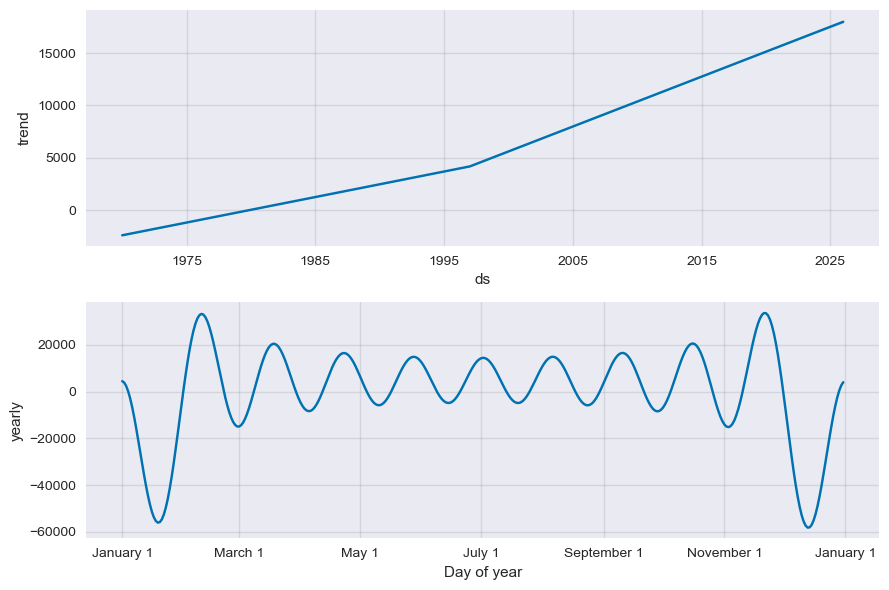

In [397]:
comp = model.plot_components(forecast)

Per quanto riguarda le mensilità, notiamo un andamento sinuisodale ma abbastanza costante con una forte discesa fra fine dicembre e gennaio probabilmente per via del capodanno lunare, successivamente le fabbriche e le attività tornano in vita e il livello di emissioni torna a salire

Analizziamo ora la situazione in Norvegia

In [398]:
from pandas import to_datetime

df =energyConsumption.copy()
df=df.iloc[:, [1, 2, 27, 58, 89]]
df=df[df['year']>=1970]
df=df.loc[df['country'].isin(["Norway"])]

df['ffprod']=df['coal_prod_per_capita']+df['gas_prod_per_capita']+df['oil_prod_per_capita']

# Rinominiamo le colonne del dataframe per come se le aspetta il modello, ovvero "ds" e "y"
df = df.rename(columns={"year": "ds", "ffprod": "y"}, errors="raise")

# Convertiamo l'anno in un formato leggibile dal modello (datetime)

#df['ds']= to_datetime(df['ds'])
df['ds'] = df['ds'].astype(str).astype('datetime64')



# Definiamo il modello
model = Prophet()
# Associamo il dataframe al modello
model.fit(df)


21:32:25 - cmdstanpy - INFO - Chain [1] start processing
21:32:25 - cmdstanpy - INFO - Chain [1] done processing


In [399]:
# Creiamo un dataframe con le date future per la previsione (in questo caso settiamo un periodo di predizione a 6 anni)
future = model.make_future_dataframe(periods=6, freq='Y')

In [400]:
# Usiamo il modello per fare una previsione
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
52,2021-12-31,"592,087.64","463,967.94","711,973.86"
53,2022-12-31,"604,016.89","483,123.40","730,662.30"
54,2023-12-31,"617,119.05","489,362.07","741,819.18"
55,2024-12-31,"623,329.04","491,853.67","752,193.86"
56,2025-12-31,"634,081.09","517,872.99","761,853.62"


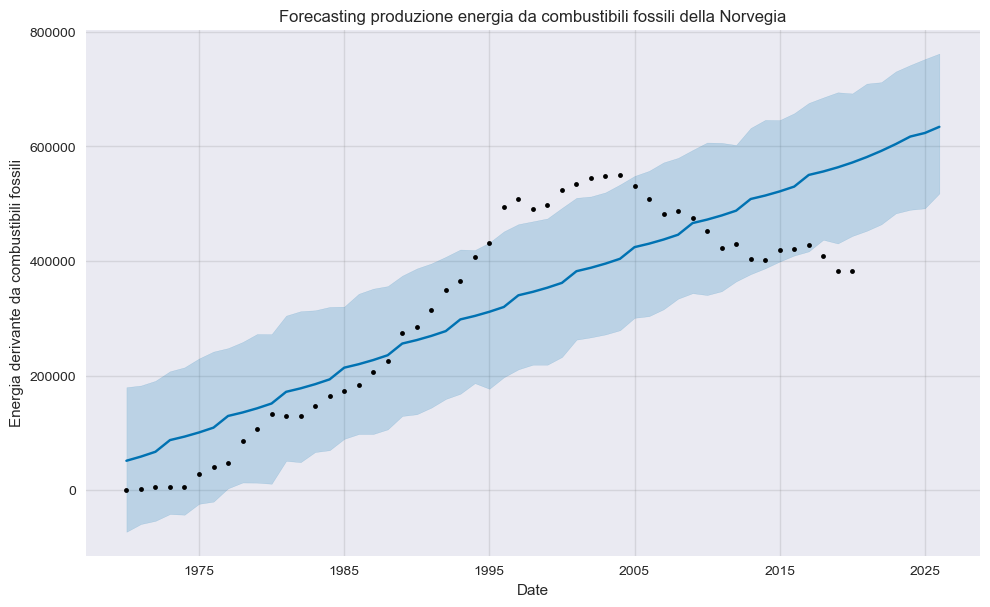

In [405]:

model.plot(forecast, xlabel = 'Date', ylabel = 'Energia derivante da combustibili fossili')
plt.title('Forecasting produzione energia da combustibili fossili della Norvegia');


Secondo il modello Prophet la Norvegia andrà a produrre sempre più energia derivante dai combustibili fossili, quindi sicuramente ci sarà qualche consumatore (vedi Cina) che ne continuerà a far uso e quindi possiamo dedurre un notevole aumento dell'inquinamento

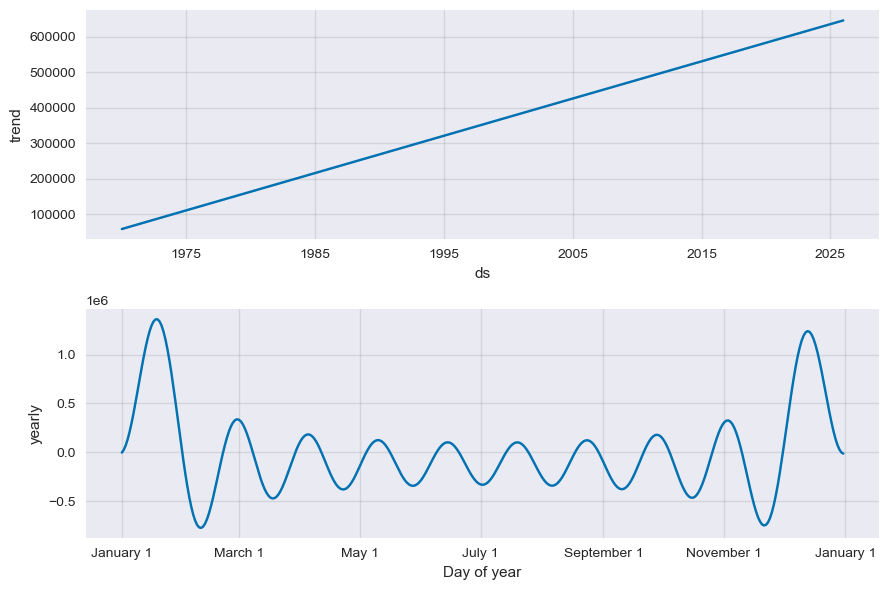

In [402]:
# Visualizziamo i trend
comp = model.plot_components(forecast)

Anche per la Norvegia, notiamo un andamento lineare (più costante rispetto quello della Cina) e un andamento sinuisodale per quanto riguarda le mensilità

# ARIMA

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Andiamo a preparare il nostro dataframe con i dati che ci interessano

In [449]:
df = energyConsumption.copy()
df=df.iloc[:, [1, 2, 27, 58, 89]]
df=df[df['year']>=1970]
df=df.loc[df['country'].isin(["Norway"])]

df['ffprod']=df['coal_prod_per_capita']+df['gas_prod_per_capita']+df['oil_prod_per_capita']

# Convertiamo l'anno in un formato leggibile dal modello (datetime)
df['year'] = df['year'].astype(str).astype('datetime64')

# Creiamo un nuovo dataframe con solamente due colonne
df = df.loc[:, ['year','ffprod']]

# Settiamo come index la colonna "year" eliminando così l'id (che non ci serve)
df = df.set_index('year', drop = True)

Prima di tutto verifichiamo se la nostra serie è stazionaria oppure no, per far questo come prima cosa facciamo un analisi grafica usando il "Rolling Mean" e "Rolling Std"

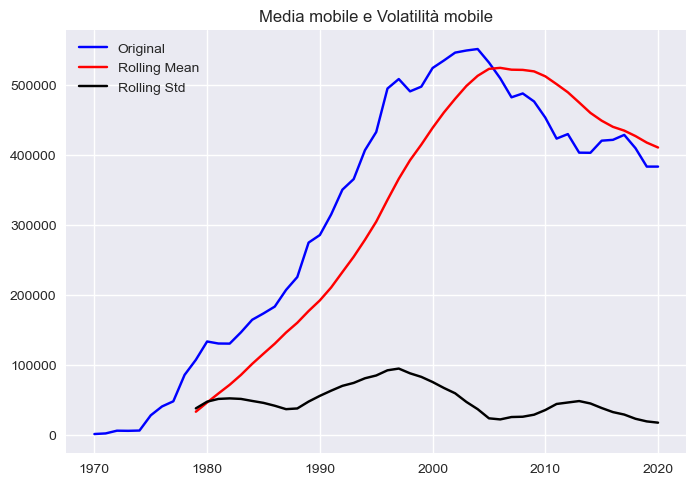

In [481]:

# .mean() Otteniamo l'andamento medio della nostra serie
rolling_mean = df.rolling(window=10).mean()

# .std() standard deviation - Con la deviazione standard mobile, possiamo ottenere una misurazione della deviazione 
# sui dati all'interno del periodo di tempo in movimento, che funge da indicatore di conferma.
rolling_std = df.rolling(window=10).std()

plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Media mobile e volatilità mobile')
plt.show()


Come possiamo notare, i due indicatori hanno un andamento non costante nel tempo e questo ci indica che la serie è non stazionaria, tuttavia, eseguiremo anche il test ADF e l'analisi statistica per ulteriori conferme

In [451]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

# Applichiamo l'ADF (Augmented Dickey–Fuller) test
# il quale viene utilizzato per determinare se una serie temporale è stazionaria o meno. 
# Una serie temporale stazionaria è quella in cui la media, la varianza e l'autocorrelazione non cambiano nel tempo.
result = adfuller(df['ffprod'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.9076086007422521
p-value: 0.32849029414966346
Critical Values:
	1%: -3.5714715250448363
	5%: -2.922629480573571
	10%: -2.5993358475635153


In questo caso, il valore p è 0,328, che è maggiore del livello di significatività di 0,05. ciò significa che la serie temporale potrebbe essere non stazionaria. Inoltre vediamo che ADF Statistic è maggiore dei valori di criticità, ulteriore conferma che la serie potrebbe essere non stazionaria.

Eseguiamo un'analisi statistica per avere un'altra prova che la nostra serie temporale sia non stazionaria

In [460]:
from numpy import log

df = energyConsumption.copy()
df=df.iloc[:, [1, 2, 27, 58, 89]]
df=df[df['year']>=1970]
df=df.loc[df['country'].isin(["Norway"])]

df['ffprod']=df['coal_prod_per_capita']+df['gas_prod_per_capita']+df['oil_prod_per_capita']

# Creiamo un nuovo dataframe con solamente due colonne
df = df.loc[:, ['year','ffprod']]

# Successivamente, possiamo dividere le serie temporali in due sequenze e quindi calcolare la media e la varianza 
# di ciascun gruppo di numeri e confrontare i valori.
series = df.values
series = log(series)
split = round(len(X) / 2)
X1, X2 = series[0:split], series[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=9.414165, mean2=10.328480
variance1=4.780470, variance2=7.424762


Anche qui vediamo che i valori, anche se non di molto, sono differenti, in più facendo un'analisi del grafico, possiamo dire che la nostra serie non è stazionaria

Visto che ARIMA si può utilizzare soltanto sulle serie stazionarie, applichiamo il metodo diff() per eseguire una differenziazione sul nostro dataframe, il quale consente di trasformare la nostra serie in stazionaria (potrebbe essere necessario applicare questo metodo N volte)

In [461]:
from pandas import Series

# Convertiamo l'anno in un formato leggibile dal modello (datetime)
df['year'] = df['year'].astype(str).astype('datetime64')

# Settiamo come index la colonna "year" eliminando così l'id (che non ci serve)
df = df.set_index('year', drop = True)

# Creiamo la serie differenziata 
diff = df.diff()
plt.plot(diff)
plt.show()

,ffprod
year,
1970-01-01,NaN
1971-01-01,870.55
1972-01-01,"3,895.22"
1973-01-01,-188.46
1974-01-01,397.72
1975-01-01,"21,742.69"
1976-01-01,"12,644.19"
1977-01-01,"7,364.08"
1978-01-01,"37,690.59"


In [496]:
# Visto che abbiamo dei valori NaN, rimpiazzo questi valori
diff = diff.fillna(method='ffill').fillna(method='bfill')

A questo punto, possiamo ripetere l'ADF test per vedere se adesso la nostra serie è stazionaria o meno

In [497]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

# Applichiamo l'ADF (Augmented Dickey–Fuller) test
# il quale viene utilizzato per determinare se una serie temporale è stazionaria o meno. 
# Una serie temporale stazionaria è quella in cui la media, la varianza e l'autocorrelazione non cambiano nel tempo.

result = adfuller(diff['ffprod'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.056780802106254
p-value: 0.0011407008582348427
Critical Values:
	1%: -3.568485864
	5%: -2.92135992
	10%: -2.5986616


Come possiamo vedere, adesso il valore p è di netto inferiore a 0,05, in più il valore statistico è inferiore a tutti i valori di criticità e quindi le condizioni per il quale potremmo avere una serie stazionaria sono soddisfatte

Procediamo con ARIMA!

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=622.482, Time=0.02 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=630.412, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=616.242, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=617.653, Time=0.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=622.687, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=618.235, Time=0.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=618.234, Time=0.05 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=617.873, Time=0.04 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=620.241, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=616.983, Time=0.02 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=616.734, Time=0.04 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=617.466, Time=0.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=616.173, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=621.831, Time=0.03 sec
 ARIMA(0,1,1)(2,1,0)[12]         

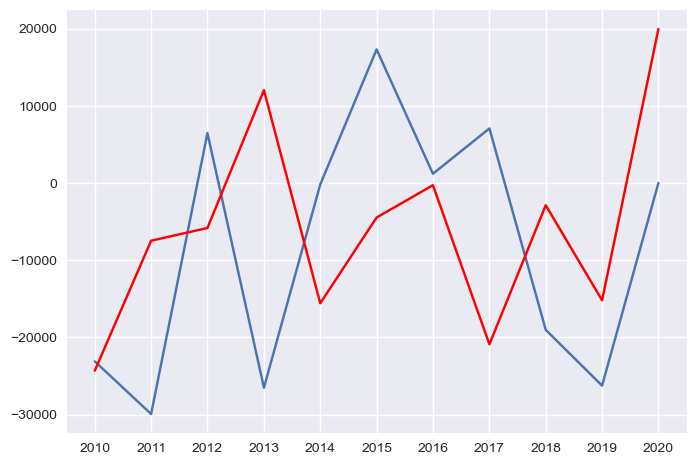

In [502]:
!pip install pmdarima
from pmdarima.arima import auto_arima

# Dividiamo i dati in serie storica e serie di test
train_data, test_data = diff[:int(len(diff)*0.8)], diff[int(len(diff)*0.8):]

# I valori p, d, q rappresentano componenti non stagionali e P, D, Q rappresentano componenti stagionali. 
model = auto_arima(train_data, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

forecast = model.predict(n_periods=len(test_data))

forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Prediction'])

# Mostro grafici
plt.plot(test_data)
plt.plot(forecast, color='red')
plt.show()

Il grafico ottenuto presenta un andamento simile ai dati di test ma non è per niente accurato

Calcoliamo l'MSE (mean squared error) per avere un indice sull'errore di previsione.
In MSE gli errori di previsione molto grandi o anomali vengono elevati al quadrato, il che a sua volta ha l'effetto di trascinare la media degli errori di previsione al quadrato, risultando in un punteggio di errore quadratico medio più elevato.

In [503]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_data.values, forecast.values)
print('MSE: %f' % mse)



MSE: 401664313.923955


# Conclusioni

Durante l'ultimo decennio c'è stato un notevole passaggio al consumo di fonti energetiche rinnovabili e a basse emissioni di carbonio in tutto il mondo e in particolare nei paesi con le Smart City più performanti.
L'Asia-Pacifico è la regione con il più alto numero di PIL pro capite e di emissioni di gas a effetto serra, nonché un enorme potenziale di consumo di energia rinnovabile/a basse emissioni di carbonio.
L'Asia-Pacifico e il Nord America sono i maggiori consumatori di energia. Tra i consumatori di fonti energetiche rinnovabili a basse emissioni di carbonio Norvegia, Canada e Svezia sono in testa alla lista.
I combustibili fossili (petrolio, gas e carbone) sono ancora le fonti energetiche primarie, tuttavia l'energia idroelettrica e nucleare sono le più popolari tra le fonti rinnovabili/a basse emissioni di carbonio.

In [504]:
#Conversione in slides
#jupyter nbconvert --to html --TemplateExporter.exclude_input=True Laboratorio_DS_Business.ipynb

SyntaxError: invalid syntax (475458699.py, line 2)